<a href="https://colab.research.google.com/github/eljirg/Mining-AI/blob/master/Mineral_Classifier/Mineral_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
  
# Mineral Classifier
We are going to trying classify between different class of minerals

</center>

### Todo

- [x] scrape data
- [x] structure data
- [x] load/process data
- [x] simple model (3 class)
- [ ] increase dataset (seems like too little valid now)
- [ ] use live graph instead of stacked training report
- [ ] experiment feature extractor arch.
- [ ] experiment augmentors.
- [ ] scale up (5 class)
- [ ] scale up (10 class)
- [ ] scale up (50 class)
- [ ] scale up (200 class)


<center>

![Image_Mineral](https://images.pexels.com/photos/1121123/pexels-photo-1121123.jpeg?cs=srgb&dl=closeup-photo-of-purple-gemstones-1121123.jpg&fm=jpg)


</center>





In [ ]:
from __future__ import print_function, division

# general package
import os, copy, time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

# deeplearning package
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

# utillities
from google.colab import drive
drive.mount('/content/drive')
plt.ion()   # interactive mode

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# functions

def load_data(data_dir, resize=224, batch_size=8, num_workers=4):
    """create Dataloaders and dataset info"""
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(resize),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(resize),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
             for x in ['train', 'val']}
    data_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=batch_size,
                                                   shuffle=True, num_workers=num_workers)
                    for x in ['train', 'val']}
    dataset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}
    class_names = dsets['train'].classes

    return data_loaders, dataset_sizes, class_names

def imshow(inp, title=None):
    """imshow for tensor"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
# set device (cpu/gpu)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
# Note on folder structure

"""
To create dataset it is quite convenient to follow the structure below

/root/train/class1/image001.jpg
/root/train/class1/image002.jpg
/root/train/class2/image001.jpg
.
.
/root/train/class5/image009.jpg

/root/val/class1/image011.jpg
/root/val/class1/image012.jpg
/root/val/class2/image011.jpg
.
.
/root/val/class5/image012.jpg

"""
print()

In [ ]:
# load data, creat dataloader, and settings
data_dir = 'drive/My Drive/Colab/Dataset/Rockpile_subset/'
resize = 224
batch_size = 16

data_loaders, dataset_sizes, class_names = load_data(data_dir, resize, batch_size)

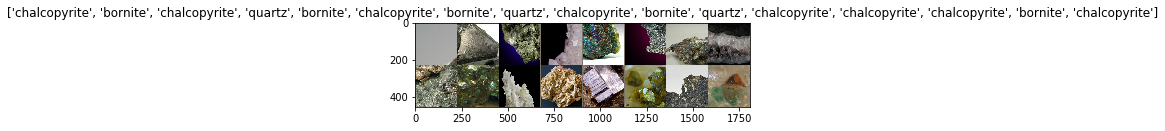

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


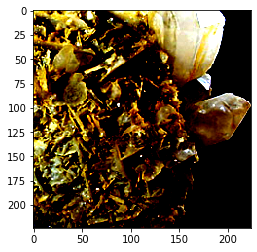

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(data_loaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


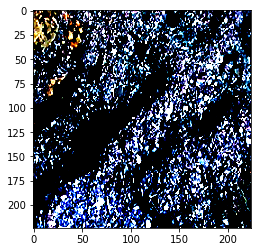

In [ ]:
# Show single image
inputs, classes = next(iter(data_loaders['train']))
plt.imshow(inputs[0].permute(1, 2, 0))

In [ ]:
# Create model
model_ft = models.resnet18(pretrained=True)                                               # try dense / mobile
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names)) # number of class

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)                   # try that newer adam

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)             


In [ ]:
# Train model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=250)

Epoch 0/249
----------
train Loss: 0.8839 Acc: 0.5951
val Loss: 0.6231 Acc: 0.7333

Epoch 1/249
----------
train Loss: 0.6139 Acc: 0.7520
val Loss: 0.4534 Acc: 0.8667

Epoch 2/249
----------
train Loss: 0.5199 Acc: 0.7784
val Loss: 0.5974 Acc: 0.6333

Epoch 3/249
----------
train Loss: 0.4802 Acc: 0.8039
val Loss: 0.4818 Acc: 0.7000

Epoch 4/249
----------
train Loss: 0.4582 Acc: 0.8118
val Loss: 0.6416 Acc: 0.7333

Epoch 5/249
----------
train Loss: 0.4257 Acc: 0.8353
val Loss: 0.4165 Acc: 0.7333

Epoch 6/249
----------
train Loss: 0.4015 Acc: 0.8324
val Loss: 0.4728 Acc: 0.7667

Epoch 7/249
----------
train Loss: 0.3111 Acc: 0.8794
val Loss: 0.3246 Acc: 0.8333

Epoch 8/249
----------
train Loss: 0.3004 Acc: 0.8961
val Loss: 0.3328 Acc: 0.8667

Epoch 9/249
----------
train Loss: 0.2919 Acc: 0.8922
val Loss: 0.3214 Acc: 0.8667

Epoch 10/249
----------
train Loss: 0.2795 Acc: 0.8990
val Loss: 0.3256 Acc: 0.8000

Epoch 11/249
----------
train Loss: 0.2825 Acc: 0.8824
val Loss: 0.3342 Acc

In [ ]:
# Save model 
torch.save(model_ft.state_dict(), 'checkpoint.pth')

In [ ]:
# Load model
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)

    model_ft = models.resnet18(pretrained=True)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, len(class_names))

    model_ft.load_state_dict(checkpoint)
    
    return model_ft

In [ ]:
model_ft = load_checkpoint('checkpoint.pth')
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


target class:  chalcopyrite
predicted class:  chalcopyrite


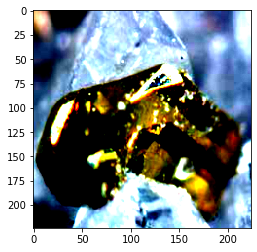

In [ ]:
# pred single

# Show single image
inputs, classes = next(iter(data_loaders['train']))
plt.imshow(inputs[0].permute(1, 2, 0))
print('target class: ', class_names[classes[0]])

model_ft.eval()   # Set model to evaluate mode
sample_pred = model_ft(inputs[0:1])
sample_pred

_, preds = torch.max(sample_pred, 1)
print('predicted class: ', class_names[preds])

# To do: show all probability for all class

In [ ]:
class_dict = {x : class_names[x] for x in range(len(class_names))}
class_dict

{0: 'bornite', 1: 'chalcopyrite', 2: 'quartz'}

# Experiment

![Image_Mineral](https://slackmojis.com/emojis/2285-banana_parrot/download)
![Image_Mineral](https://slackmojis.com/emojis/3932-boba-parrot/download)
![Image_Mineral](https://slackmojis.com/emojis/2289-coffee_parrot/download)
![Image_Mineral](https://emojis.slackmojis.com/emojis/images/1495224258/2297/halal_parrot.gif?1495224258)
![Image_Mineral](https://slackmojis.com/emojis/2298-hamburger_parrot/download)
![Image_Mineral](https://slackmojis.com/emojis/984-ice_cream_parrot/download)
![Image_Mineral](https://slackmojis.com/emojis/2305-parrot_beer/download)
![Image_Mineral](https://slackmojis.com/emojis/2308-pizza_parrot/download)

![Image_Mineral](https://media.giphy.com/media/3o6ozxZ37wJbc2N8TS/giphy.gif)
![Image_Mineral](https://media2.giphy.com/media/TGKwNUQ11E9LnACDLe/giphy.webp?cid=790b76112628f0c9fcf53be0d359cd0f29073ed48b90c324&rid=giphy.webp)
![Image_Mineral](https://media2.giphy.com/media/Q8YYX4rpTwWoU/giphy.webp?cid=790b761138af6169cda1ca579c470fc9f8fef782635726b1&rid=giphy.webp)




